## 0. Setting Data and Enviroment

In [91]:
# Liberary import(#개인적으로 지금까지 해오던거 복붙)

import pandas as pd
import numpy as np
import os 
import time 
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

# Preprocessing
from scipy.stats import ttest_ind, pointbiserialr, chi2_contingency, spearmanr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, roc_curve, confusion_matrix, accuracy_score
from sklearn import svm
import scipy.stats as stats


# Model(Classification)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier




# Warning Exception
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set(style = 'whitegrid', font_scale=1.1)

In [76]:
og_df = pd.read_csv('stroke_dataset.csv')

og_df.head

<bound method NDFrame.head of          id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban   

## 1. EDA
 - 결측값 확인
 - 데이터에 대한 이해
 - Feature 및 Error 확인
 - 변수 간 관계 확인 

In [77]:
print(og_df.info())
print()
print(f"shape : {og_df.shape}")
print(og_df.describe())
print(og_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

shape : (5110, 12)
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
me

In [78]:
print (f'{round(df["gender"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="gender", title='Gender', width=400, height=400)
fig.show()
print (f'{round(df["hypertension"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="hypertension", title='hypertension', width=400, height=400)
fig.show()
print (f'{round(df["heart_disease"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="heart_disease", title='heart_disease', width=400, height=400)
fig.show()
print (f'{round(df["Residence_type"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="Residence_type", title='Residence_type', width=400, height=400)
fig.show()
print (f'{round(df["smoking_status"].value_counts(normalize=True)*100,2)}')
fig = px.histogram(df, x="smoking_status", title='smoking_status', width=400, height=400)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

gender
0    58.6
1    41.4
Name: proportion, dtype: float64


hypertension
0    90.25
1     9.75
Name: proportion, dtype: float64


heart_disease
0    94.6
1     5.4
Name: proportion, dtype: float64


Residence_type
1    50.81
0    49.19
Name: proportion, dtype: float64


smoking_status
2    37.03
0    30.22
1    17.30
3    15.44
Name: proportion, dtype: float64


In [79]:
TARGET = 'stroke'
BASE = [col for col in df.columns if col not in [TARGET]]
Categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical = [col for col in BASE if col not in Categorical]

print(f'{len(BASE)} 기본 피쳐(모델에 영향을 줄 수 있는 변수):{BASE}')
print(f'{len(Categorical)} 범주형 변수:{Categorical}')
print(f'{len(Numerical)} 수치형 변수:{Numerical}')
df.nunique()

10 기본 피쳐(모델에 영향을 줄 수 있는 변수):['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
7 범주형 변수:['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
3 수치형 변수:['age', 'avg_glucose_level', 'bmi']


gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3374
bmi                   489
smoking_status          4
stroke                  2
dtype: int64

In [87]:
results = []
categorical_col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_col:
    # 교차표 생성
    contingency_table = pd.crosstab(df[col], df[TARGET])
    # 카이제곱 검정
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    results.append({
        'Variable': col,
        'Type': 'Categorical',
        'Test': 'Chi-square',
        'P-value': p,
        'Significant': p < 0.05
    })
    
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

group_stroke = df[df['stroke'] == 1]
group_normal = df[df['stroke'] == 0]

for col in numeric_cols:
    t_stat, p = stats.ttest_ind(group_stroke[col], group_normal[col], equal_var=False) # Welch's T-test
    results.append({
        'Variable': col,
        'Type': 'Numerical',
        'Test': 'T-test',
        'P-value': p,
        'Significant': p < 0.05
    })
  
results_df = pd.DataFrame(results)
results_df['P-value'] = results_df['P-value'].apply(lambda x: f"{x:.5f}" if x >= 0.00001 else "< 0.00001")
print(results_df)  
    

            Variable         Type        Test    P-value  Significant
0             gender  Categorical  Chi-square    0.55983        False
1       hypertension  Categorical  Chi-square  < 0.00001         True
2      heart_disease  Categorical  Chi-square  < 0.00001         True
3       ever_married  Categorical  Chi-square  < 0.00001         True
4          work_type  Categorical  Chi-square  < 0.00001         True
5     Residence_type  Categorical  Chi-square    0.29983        False
6     smoking_status  Categorical  Chi-square  < 0.00001         True
7                age    Numerical      T-test  < 0.00001         True
8  avg_glucose_level    Numerical      T-test  < 0.00001         True
9                bmi    Numerical      T-test    0.00008         True


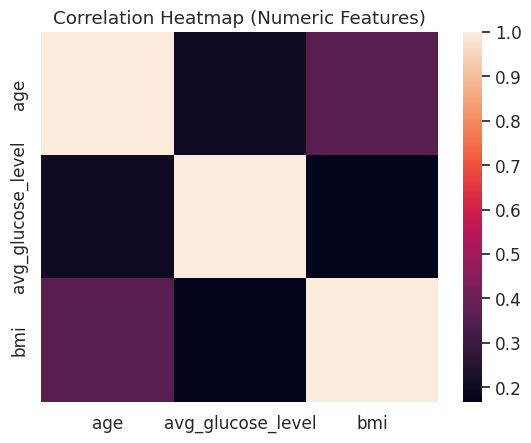

In [81]:
corr = df[Numerical].corr()

sns.heatmap(corr)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

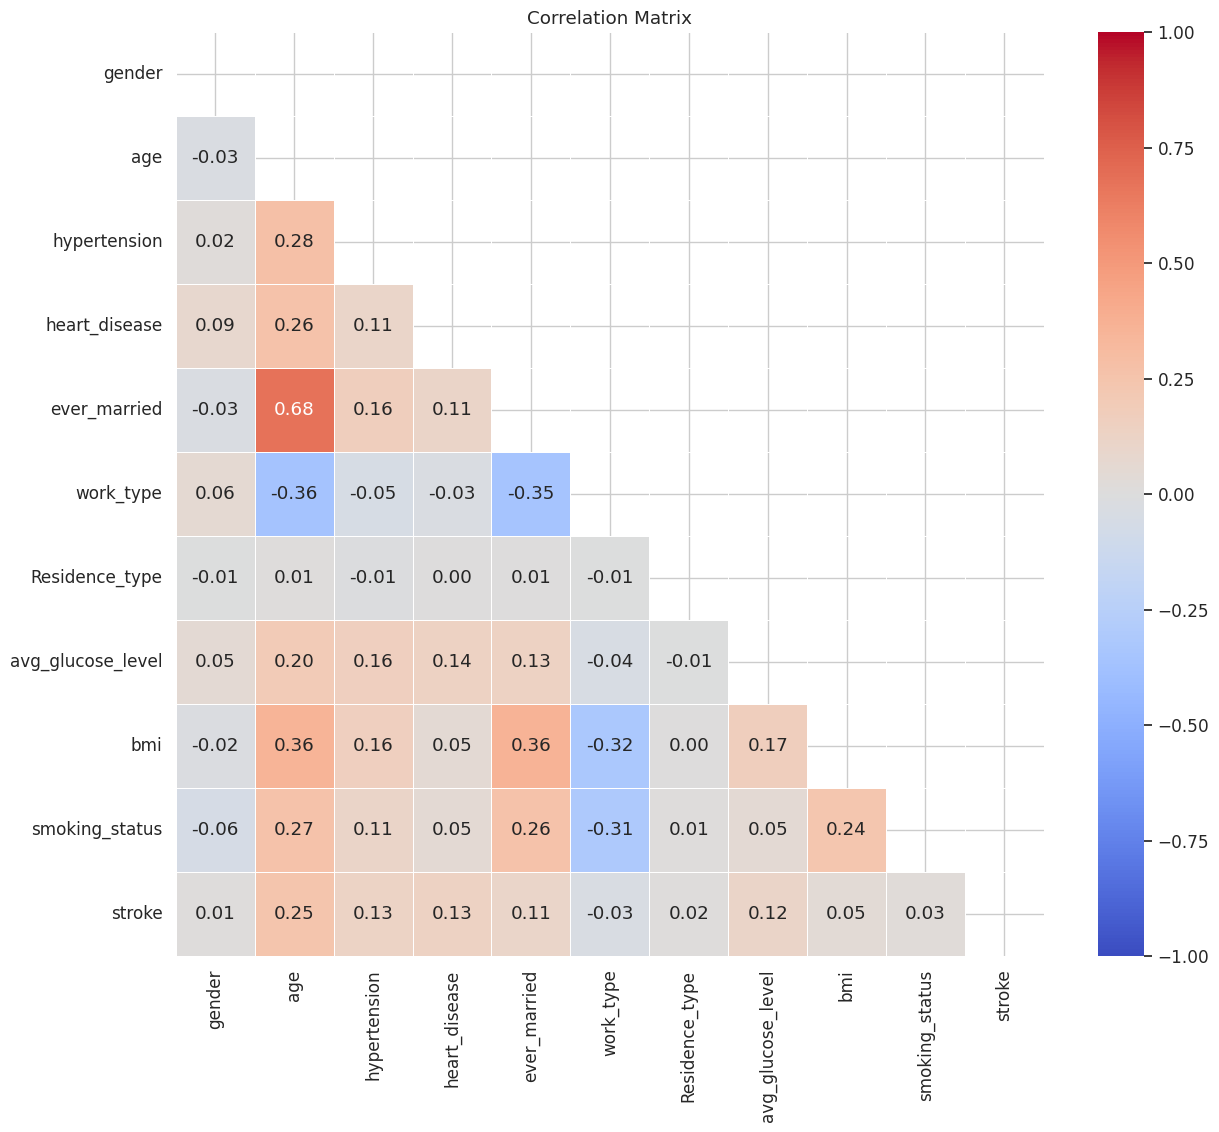

In [ ]:
le = LabelEncoder()
for col in Categorical:
    df[col] = le.fit_transform(df[col])


corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('correlation_heatmap.png')
plt.show()

## 2. Preprocessing
### 1) 결측값 처리
 - BMI 결측값 분포도를 확인, 고령 및 뇌졸중 비율이 높음
 - 일반적인 대체 방법(mean, Median) 활용 시 Bias 가 발생할 수 있음을 확인 함
   - (Age Label-Encoding vs KNN Imutation 과 확연한 차이를 보임)
 - 방법 중 둘 사이에 큰 차이가 없어 임의로 KNN Imutation 방법을 활용
   - KNN Imutation: 인접한 특성의 데이터들의 평균을 대치하기로 함

### 2) Labeling(범주형 -> 수치형)
 - One-Hot Encoding vs Label Encoding -> 0, 1 Data 보다 더 label하면 좋은 데이터가 더 많음
   - 추가적으로 편향적인 결과가 있다면[Gender, Age etc..], SMOTE 방식도 적용해 볼 것

### 3) Split DATA
 - 대표적 비율인 Train(80%) vs Test(20%) -> test_size=0.2 로 적용

### 4) Noramalization and Standard
 - data 스케일링 

In [100]:

"""
# 중앙값으로 대체 시 성능을 저하시킴 #
target_cols = "BMI"
df[target_cols] = df[target_cols].fillna(df[])
"""
df = og_df.drop('id', axis=1).copy()
df = df.drop(df[(df['gender'] == 'Other')].index, inplace= False)
print(df)

imputer = KNNImputer(n_neighbors=5)
target_cols = ['age', 'avg_glucose_level', 'hypertension', 'heart_disease', 'stroke', 'bmi']
df[target_cols] = imputer.fit_transform(df[target_cols])

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


def outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    return df

df = outliers(df, 'avg_glucose_level')
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df = outliers(df, 'bmi')


print(f"shape : {og_df.shape}")
print(f"bmi null is :{df['bmi'].isnull().sum()}")

le = LabelEncoder()
for col in Categorical:
    df[col] = le.fit_transform(df[col])

      gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smok

In [101]:
X = df.drop(columns=[TARGET])
Y = df[TARGET]
print(f"Split 전 세트: {df.shape[0]} ")
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


print(f"✓ 학습 세트: {X_train.shape[0]} (뇌졸증: {Y_train.sum()}, {Y_train.mean():.2%})")
print(f"✓ 테스트 세트: {X_test.shape[0]} (뇌졸증: {Y_test.sum()}, {Y_test.mean():.2%})")

Split 전 세트: 5109 
✓ 학습 세트: 4087 (뇌졸증: 199.0, 4.87%)
✓ 테스트 세트: 1022 (뇌졸증: 50.0, 4.89%)


In [102]:
ss = StandardScaler()
ss.fit(X_train)


X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## 3. Machine Learning Model
 - KNN model
 - Logistic Regression
 - Decision Tree
 - Random Forest
 - Boosting Model(XGB)

### 성능검사(ROC Curves Comparision)


Model Performance Comparison:
                     Model  Accuracy  Precision  Recall  F1-Score       AUC
0      Logistic Regression  0.951076    0.00000    0.00  0.000000  0.836790
3  Gradient Boosting (XGB)  0.948141    0.20000    0.02  0.036364  0.826667
2            Random Forest  0.949119    0.00000    0.00  0.000000  0.783014
4                      KNN  0.950098    0.40000    0.04  0.072727  0.602572
1            Decision Tree  0.909980    0.16129    0.20  0.178571  0.573251


([<matplotlib.axis.YTick at 0x724ef0e57430>,
 [Text(0, 0.5, 'Normal (0)'), Text(0, 1.5, 'Fraud (1)')])

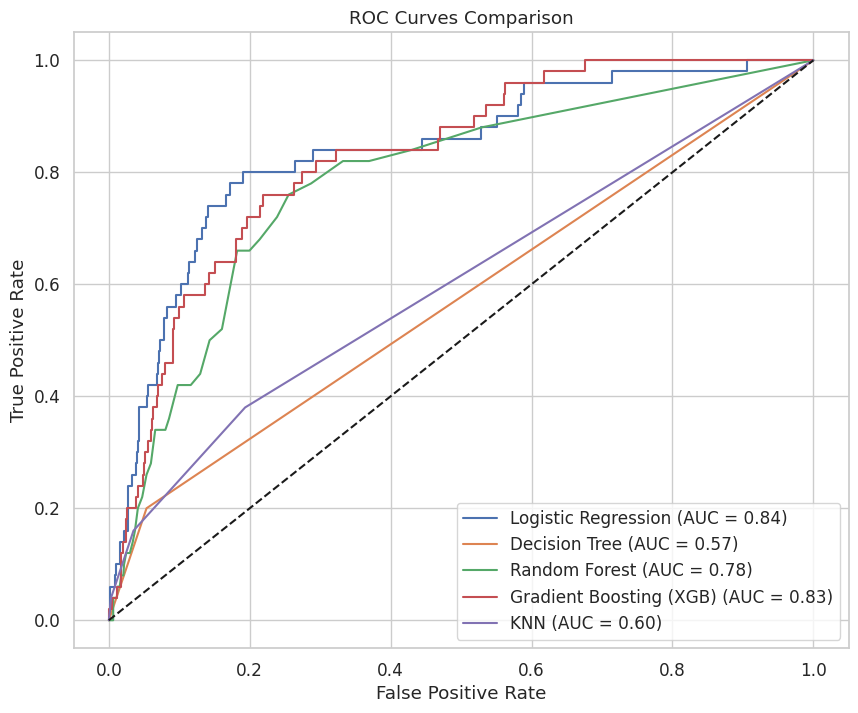

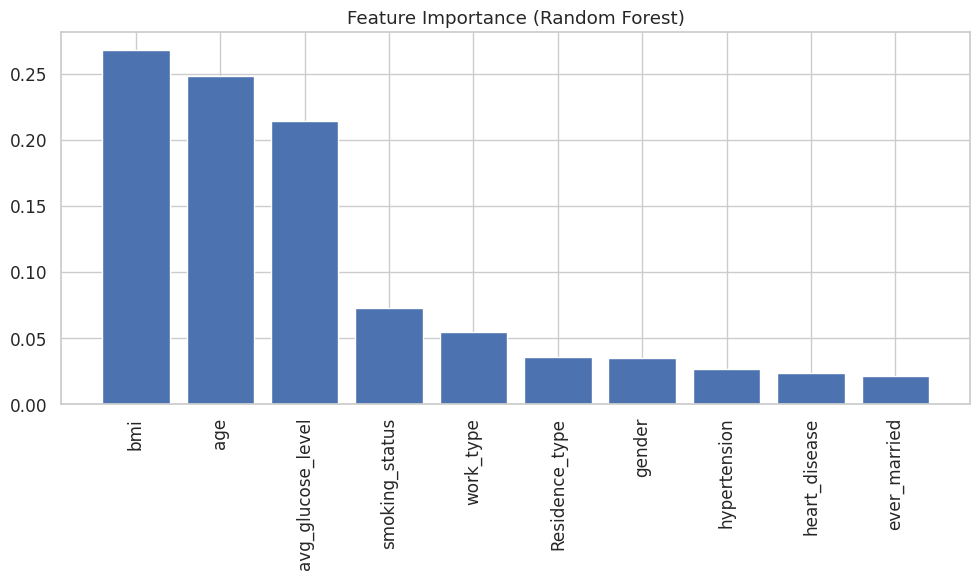

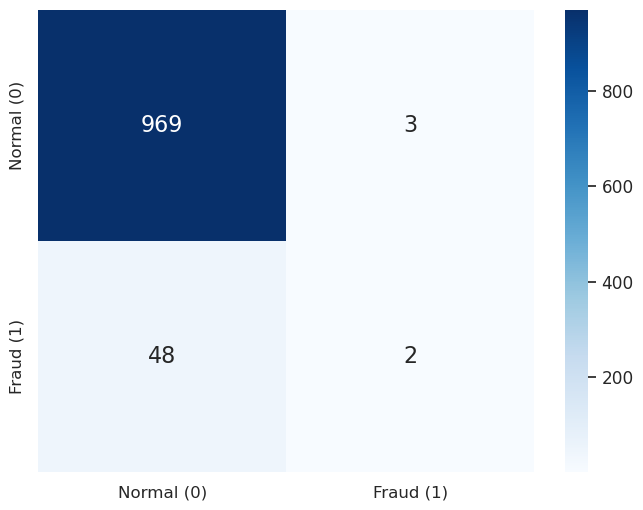

In [103]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting (XGB)": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = []
plt.figure(figsize=(10, 8))


for name, model in models.items():
    # 학습
    model.fit(X_train_scaled, Y_train)
    
    # 예측
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # 성능 지표 계산
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_prob)
    
    cm = confusion_matrix(Y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })
    
    # ROC Curve 그리기
    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()

results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)

rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xticks([0.5, 1.5], ['Normal (0)', 'Fraud (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Normal (0)', 'Fraud (1)'], fontsize=12)

## 추가로 진행

### ++ SMOTE 적용 및 Weight 적용

Original Train Count: {0: 3888, 1: 199}
SMOTE Train Count: {0: 3888, 1: 3888}


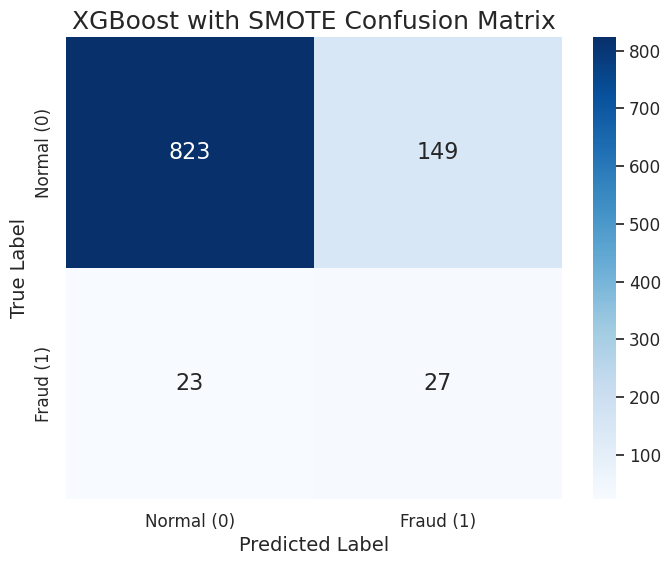


[Classification Report with SMOTE]
=== 평가 지표 (Evaluation Metrics) ===
F1 Score      : 0.2389
AUC-ROC Score : 0.7903
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.15      0.54      0.24        50

    accuracy                           0.83      1022
   macro avg       0.56      0.69      0.57      1022
weighted avg       0.93      0.83      0.87      1022



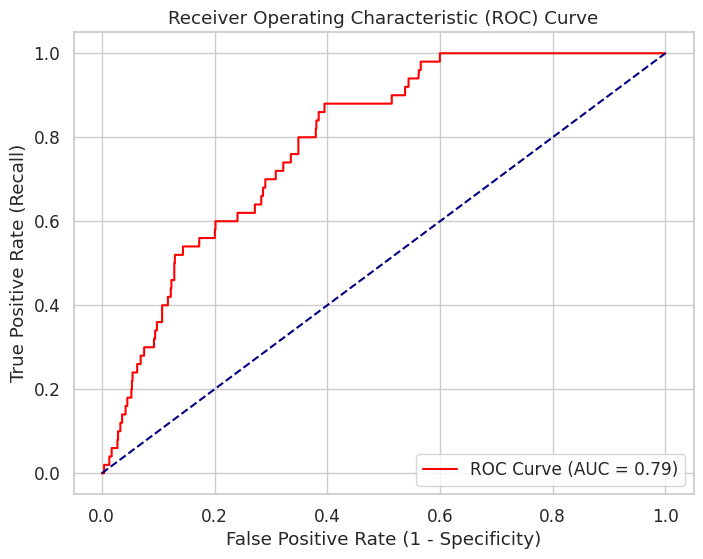

In [113]:
df = pd.read_csv('stroke_dataset.csv')

# 결측치 처리
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 이상치 처리 (Capping)
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper, upper, df[col])
    df[col] = np.where(df[col] < lower, lower, df[col])
    return df

for col in ['avg_glucose_level', 'bmi']:
    df = cap_outliers(df, col)

# 통계적으로 유의하지 않은 변수 제거 (Gender, Residence_type, id)
# 'Other' 성별 제거 포함
df = df[df['gender'] != 'Other']
df_final = df.drop(['id', 'gender', 'Residence_type'], axis=1)

# 범주형 변수 인코딩
df_final = pd.get_dummies(df_final, columns=['ever_married', 'work_type', 'smoking_status'], drop_first=True)

# 데이터 분리
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

# 스케일링 (SMOTE 전에 스케일링을 하는 것이 좋음, 단 Train/Test 분리 후 하는 것이 정석이나 편의상 전체 적용 후 분리 시 누수 주의. 
# 여기서는 정석대로 분리 후 스케일링 진행)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 2. SMOTE 적용 (Train 데이터에만 적용!)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original Train Count: {y_train.value_counts().to_dict()}")
print(f"SMOTE Train Count: {y_train_smote.value_counts().to_dict()}")

# 3. 모델 정의
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_smote, y_train_smote)

# 5. 예측
y_pred = model.predict(X_test_scaled)

# 6. 결과 시각화 (Confusion Matrix)
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('XGBoost with SMOTE Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks([0.5, 1.5], ['Normal (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Normal (0)', 'Fraud (1)'])
plt.show()

# 7. 상세 리포트 출력
print("\n[Classification Report with SMOTE]")

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 2. 점수 계산 및 출력
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"=== 평가 지표 (Evaluation Metrics) ===")
print(f"F1 Score      : {f1:.4f}")
print(f"AUC-ROC Score : {roc_auc:.4f}")
print("-" * 30)
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

계산된 가중치(scale_pos_weight): 19.54


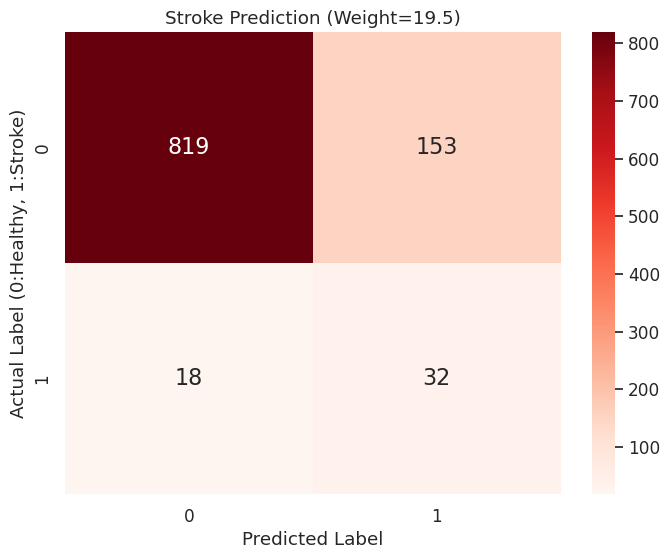


[Evaluation Report]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       972
           1       0.17      0.64      0.27        50

    accuracy                           0.83      1022
   macro avg       0.58      0.74      0.59      1022
weighted avg       0.94      0.83      0.87      1022

AUC-ROC Score: 0.8344


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

df = pd.read_csv('stroke_dataset.csv')

if 'id' in df.columns:
    df = df.drop('id', axis=1)

# (2) 결측치(NaN) 처리 - bmi 컬럼에 빈 값이 보임 -> 평균값으로 채움
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# (3) 문자열을 숫자로 변환 (One-Hot Encoding)
# gender, work_type 같은 글자 데이터를 0과 1로 변환합니다.
df = pd.get_dummies(df, drop_first=True)

# ----------------------------------------------------

# 2. X, y 분리 (타겟 컬럼명은 보통 'stroke' 입니다)
X = df.drop('stroke', axis=1)
y = df['stroke']

# 3. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

neg_count = y_train.value_counts()[0]  
pos_count = y_train.value_counts()[1]  
weight = neg_count / pos_count

print(f"계산된 가중치(scale_pos_weight): {weight:.2f}")


model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,       
    max_depth=4,              
    scale_pos_weight=weight,  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# 6. 예측 및 평가
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 7. 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 16})
plt.title(f'Stroke Prediction (Weight={weight:.1f})')
plt.ylabel('Actual Label (0:Healthy, 1:Stroke)')
plt.xlabel('Predicted Label')
plt.show()

# 8. 점수 리포트
print("\n[Evaluation Report]")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

SMOTE 전: [3889  199]
SMOTE 후: [3889 3889]


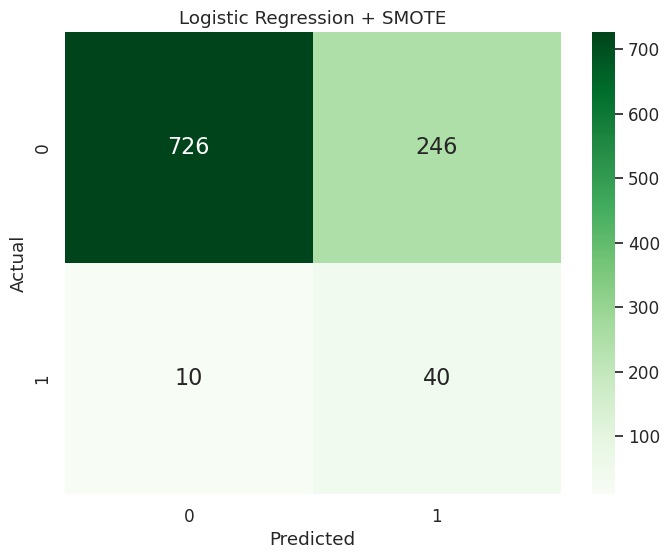


[Logistic Regression with SMOTE Report]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

AUC-ROC Score: 0.8448


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. 데이터 로드
df = pd.read_csv('stroke_dataset.csv')

# --- [전처리: 로지스틱 회귀를 위한 필수 작업] ---

# (1) ID 제거
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# (2) 결측치 처리
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# (3) 문자 -> 숫자 변환 (One-Hot Encoding)
df = pd.get_dummies(df, drop_first=True)

# ------------------------------------------------

# 2. X, y 분리
X = df.drop('stroke', axis=1)
y = df['stroke']

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. [중요] 스케일링 (Logistic Regression은 필수!)
# 평균 0, 분산 1로 데이터를 맞춰줍니다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. [핵심] SMOTE 적용 (학습 데이터에만)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE 전: {np.bincount(y_train)}")
print(f"SMOTE 후: {np.bincount(y_train_smote)}")

# 6. 로지스틱 회귀 모델 학습
# max_iter를 늘려줘야 충분히 학습합니다.
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_smote, y_train_smote)

# 7. 예측 및 평가
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 8. 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16})
plt.title('Logistic Regression + SMOTE')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 9. 성적표 확인
print("\n[Logistic Regression with SMOTE Report]")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

적용된 가중치(scale_pos_weight): 19.54


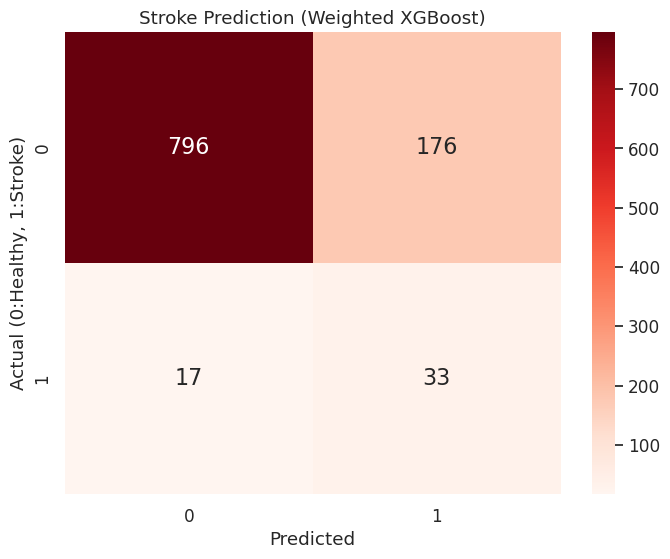


[Final Evaluation]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       972
           1       0.16      0.66      0.25        50

    accuracy                           0.81      1022
   macro avg       0.57      0.74      0.57      1022
weighted avg       0.94      0.81      0.86      1022

AUC-ROC Score: 0.8227


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# 1. 데이터 로드
df = pd.read_csv('stroke_dataset.csv')

# --- [필수 전처리: 이 부분이 빠지면 점수가 안 나옵니다] ---

# (1) ID 제거 (예측에 방해됨)
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# (2) BMI 결측치 채우기 (평균값 대입)
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# (3) 문자열 -> 숫자 변환 (One-Hot Encoding)
# gender, work_type 등의 글자를 0/1로 자동 변환해줍니다.
df = pd.get_dummies(df, drop_first=True)

# --------------------------------------------------------

# 2. 데이터 분리
X = df.drop('stroke', axis=1)
y = df['stroke']

# stratify=y를 통해 학습/테스트 셋의 환자 비율을 일정하게 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 가중치(Weight) 계산 - 모델이 환자를 무시하지 못하게 함
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight = neg_count / pos_count

print(f"적용된 가중치(scale_pos_weight): {scale_pos_weight:.2f}")

# 4. XGBoost 모델 정의 (Logistic Regression보다 훨씬 똑똑함)
model = XGBClassifier(
    n_estimators=300,          # 학습 횟수 증가
    learning_rate=0.05,        # 천천히 꼼꼼하게 학습
    max_depth=3,               # 뇌졸중 데이터는 복잡하지 않아 깊이를 낮춤 (과적합 방지)
    scale_pos_weight=scale_pos_weight, # ★핵심: 환자 데이터에 가산점 부여
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 6. 결과 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 16})
plt.title('Stroke Prediction (Weighted XGBoost)')
plt.ylabel('Actual (0:Healthy, 1:Stroke)')
plt.xlabel('Predicted')
plt.show()

# 7. 진짜 성적표 확인 (Recall과 AUC를 동시에 보세요)
print("\n[Final Evaluation]")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

## 결론
### 뇌졸증 예측(분류모델)을 목표로 다양한 모델들을 개발
 - 결측치 처리
 - 이상치 처리
 - 예측 모델 실행
 - 추가적으로 하이퍼 파라미터 및 데이터 불균형(SMOTE) 및 가중치 계산(scale pos weight) 적용

### 모델의 적용
 - 기본적인 모델을 돌렸을 때, Rogistic Regression이 0.83으로 가장 높았음
 - 다음으로 높았던 모델이 XGB 모델이었으며, Boost모델들을 돌려보았을 때에도 분류는 Gradient Boosting이 가장 높음
 - 주요 변수들 중에서는 수치형[BMI, Age, AVG_gucose_level]이 가장 높음
 	- Correlation Matrix에서 비슷한 결과를 보여주었음
    
### 추가적으로 다양한 모델들에 하이퍼 파라미터 및 전처리를 새롭게 적용해보았음
 - SMOTE + Weight -> 다른 모델에서는 오히려 낮아졌으나(0.79), Rogistic Regression 모델은 0.061정도의 모델 성능의 향상을 보임
 - 기본적으로 Stroke 환자의 수가 너무 적어서 편향적 오류가 발생함(Confusion Matrix)
 - 결과적으로 SMOTE와 가중치를 새롭게 적용한 Rogistic Regression model이 성능이 가장 좋았음
 